In [98]:
from itertools import combinations, product, islice
import textwrap
import pandas as pd
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import drawsvg as dw

In [99]:
def extract_same_line_codes(station_codes, line_codes):
    if type(line_codes) is not list:
        line_codes = [line_codes]
    return [sub_code for code in station_codes for sub_code in code.split('/') if sub_code[:2] in line_codes]


In [100]:
hours = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]
day_types = ['WEEKDAY', 'WEEKENDS/HOLIDAY']

all_lines = {
    'NSL': {
        'station_codes': ["EW24/NS1", "NS2", "NS3", "NS4/BP1", "NS5", "NS7", "NS8", "NS9/TE2", "NS10", "NS11", "NS12", "NS13", "NS14", "NS15", "NS16", "NS17/CC15", "NS18", "NS19", "NS20", "NS21/DT11", "TE14/NS22", "NS23", "NS24/NE6/CC1", "NS25/EW13", "EW14/NS26", "NS27/CE2/TE20", "NS28"],
        'travel_times': [3, 2, 5, 2, 5, 3, 2, 3, 4, 2, 3, 3, 5, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2],
        'line_prefixes': ['NS'],
        'line_color': (209, 60, 50),
        'train_capacity': 1920,
        'seat_capacity': 264
    },
    'EWL': {
        'station_codes': ['EW1', 'EW2/DT32', 'EW3', 'EW4', 'EW5', 'EW6', 'EW7', 'EW8/CC9', 'EW9', 'EW10', 'EW11', 'EW12/DT14', 'NS25/EW13', 'EW14/NS26', 'EW15', 'EW16/NE3/TE17', 'EW17', 'EW18', 'EW19', 'EW20', 'EW21/CC22', 'EW22', 'EW23', 'EW24/NS1', 'EW25', 'EW26', 'EW27', 'EW28', 'EW29', 'EW30', 'EW31', 'EW32', 'EW33'],
        'travel_times': [3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 4, 2, 3, 3, 2, 3, 3, 2, 3, 2],
        'line_prefixes': ['EW'],
        'line_color': (66, 148, 84),
        'train_capacity': 1920,
        'seat_capacity': 264
    },
    'EWL-CGL': {
        'station_codes': ['CG2', 'CG1/DT35', 'EW4', 'EW5', 'EW6', 'EW7', 'EW8/CC9', 'EW9', 'EW10', 'EW11', 'EW12/DT14', 'NS25/EW13', 'EW14/NS26', 'EW15', 'EW16/NE3/TE17', 'EW17', 'EW18', 'EW19', 'EW20', 'EW21/CC22', 'EW22', 'EW23', 'EW24/NS1', 'EW25', 'EW26', 'EW27', 'EW28', 'EW29', 'EW30', 'EW31', 'EW32', 'EW33'],
        'travel_times': [4, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 4, 2, 3, 3, 2, 3, 3, 2, 3, 2],
        'line_prefixes': ['EW', 'CG'],
        'line_color': (66, 148, 84),
        'train_capacity': 1920,
        'seat_capacity': 264
    },
    'NEL': {
        'station_codes': ['NE1/CC29', 'EW16/NE3/TE17', 'NE4/DT19', 'NE5', 'NS24/NE6/CC1', 'NE7/DT12', 'NE8', 'NE9', 'NE10', 'NE11', 'NE12/CC13', 'NE13', 'NE14', 'NE15', 'NE16/STC', 'NE17/PTC'],
        'travel_times': [3, 2, 2, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 2, 3],
        'line_prefixes': ['NE'],
        'line_color': (133, 69, 149),
        'train_capacity': 1920,
        'seat_capacity': 268
    },
    'CCL': {
        'station_codes': ['NS24/NE6/CC1', 'CC2', 'CC3', 'CC4/DT15', 'CC5', 'CC6', 'CC7', 'CC8', 'EW8/CC9', 'CC10/DT26', 'CC11', 'CC12', 'NE12/CC13', 'CC14', 'NS17/CC15', 'CC16', 'CC17/TE9', 'CC19/DT9', 'CC20', 'CC21', 'EW21/CC22', 'CC23', 'CC24', 'CC25', 'CC26', 'CC27', 'CC28', 'NE1/CC29'],
        'travel_times': [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        'line_prefixes': ['CC'],
        'line_color': (236, 161, 68),
        'train_capacity': 931,
        'seat_capacity': 146
    },
    'CCL-CEL': {
        'station_codes': ['CE1/DT16', 'NS27/CE2/TE20', 'CC4/DT15', 'CC5', 'CC6', 'CC7', 'CC8', 'EW8/CC9', 'CC10/DT26', 'CC11', 'CC12', 'NE12/CC13', 'CC14', 'NS17/CC15', 'CC16', 'CC17/TE9', 'CC19/DT9', 'CC20', 'CC21', 'EW21/CC22', 'CC23', 'CC24', 'CC25', 'CC26', 'CC27', 'CC28', 'NE1/CC29'],
        'travel_times': [2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        'line_prefixes': ['CE', 'CC'],
        'line_color': (236, 161, 68),
        'train_capacity': 931,
        'seat_capacity': 146
    },
    'TEL': {
        'station_codes': ['TE1', 'NS9/TE2', 'TE3', 'TE4', 'TE5', 'TE6', 'TE7', 'TE8', 'CC17/TE9', 'DT10/TE11', 'TE12', 'TE13', 'TE14/NS22', 'TE15', 'TE16', 'EW16/NE3/TE17', 'TE18', 'TE19', 'NS27/CE2/TE20', 'TE22'],
        'travel_times': [3, 3, 4, 4, 2, 2, 3, 3, 4, 3, 2, 2, 3, 1, 3, 1, 2, 2, 3],
        'line_prefixes': ['TE'],
        'line_color': (148, 94, 49),
        'train_capacity': 1280,
        'seat_capacity': 156
    },
    'DTL': {
        'station_codes': ['BP6/DT1', 'DT2', 'DT3', 'DT5', 'DT6', 'DT7', 'DT8', 'CC19/DT9', 'DT10/TE11', 'NS21/DT11', 'NE7/DT12', 'DT13', 'EW12/DT14', 'CC4/DT15', 'CE1/DT16', 'DT17', 'DT18', 'NE4/DT19', 'DT20', 'DT21', 'DT22', 'DT23', 'DT24', 'DT25', 'CC10/DT26', 'DT27', 'DT28', 'DT29', 'DT30', 'DT31', 'EW2/DT32', 'DT33', 'DT34', 'CG1/DT35'],
        'travel_times': [2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2],
        'line_prefixes': ['DT'],
        'line_color': (38, 91, 163),
        'train_capacity': 931,
        'seat_capacity': 130
    },
    'SELRT': {
        'station_codes': ['NE16/STC', 'SE1', 'SE2', 'SE3', 'SE4', 'SE5', 'NE16/STC'],
        'travel_times': [1, 1, 1, 1, 1, 1],
        'line_prefixes': ['ST', 'SE'],
        'line_color': (117, 132, 116),
        'train_capacity': 105,
        'seat_capacity': 14
    },
    'SWLRT': {
        'station_codes': ['NE16/STC', 'SW1', 'SW2', 'SW3', 'SW4', 'SW5', 'SW6', 'SW7', 'SW8', 'NE16/STC'],
        'travel_times': [1, 1, 1, 1, 1, 1, 1, 1, 1],
        'line_prefixes': ['ST', 'SW'],
        'line_color': (117, 132, 116),
        'train_capacity': 105,
        'seat_capacity': 14
    },
    'PELRT': {
        'station_codes': ['NE17/PTC', 'PE1', 'PE2', 'PE3', 'PE4', 'PE5', 'PE6', 'PE7', 'NE17/PTC'],
        'travel_times': [1, 1, 1, 1, 1, 1, 1, 1],
        'line_prefixes': ['PT', 'PE'],
        'line_color': (117, 132, 116),
        'train_capacity': 105,
        'seat_capacity': 14
    },
    'PWLRT': {
        'station_codes': ['NE17/PTC', 'PW1', 'PW3', 'PW4', 'PW5', 'PW6', 'PW7', 'NE17/PTC'],
        'travel_times': [1, 1, 1, 1, 1, 1, 1],
        'line_prefixes': ['PT', 'PW'],
        'line_color': (117, 132, 116),
        'train_capacity': 105,
        'seat_capacity': 14
    },
    'BPLRT': {
        'station_codes': ['NS4/BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6/DT1', 'BP7', 'BP8', 'BP9', 'BP10', 'BP11', 'BP12', 'BP13', 'BP6/DT1', 'BP5', 'BP4', 'BP3', 'BP2', 'NS4/BP1'],
        'travel_times': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        'line_prefixes': ['BP'],
        'line_color': (117, 132, 116),
        'train_capacity': 105,
        'seat_capacity': 16
    }
}

prefix_colors = {
    prefix: data['line_color']
    for line_code, data in all_lines.items()
    for prefix in data['line_prefixes']
}

station_set = set(sum([data['station_codes'] for data in all_lines.values()], []))

station_set

{'BP10',
 'BP11',
 'BP12',
 'BP13',
 'BP2',
 'BP3',
 'BP4',
 'BP5',
 'BP6/DT1',
 'BP7',
 'BP8',
 'BP9',
 'CC10/DT26',
 'CC11',
 'CC12',
 'CC14',
 'CC16',
 'CC17/TE9',
 'CC19/DT9',
 'CC2',
 'CC20',
 'CC21',
 'CC23',
 'CC24',
 'CC25',
 'CC26',
 'CC27',
 'CC28',
 'CC3',
 'CC4/DT15',
 'CC5',
 'CC6',
 'CC7',
 'CC8',
 'CE1/DT16',
 'CG1/DT35',
 'CG2',
 'DT10/TE11',
 'DT13',
 'DT17',
 'DT18',
 'DT2',
 'DT20',
 'DT21',
 'DT22',
 'DT23',
 'DT24',
 'DT25',
 'DT27',
 'DT28',
 'DT29',
 'DT3',
 'DT30',
 'DT31',
 'DT33',
 'DT34',
 'DT5',
 'DT6',
 'DT7',
 'DT8',
 'EW1',
 'EW10',
 'EW11',
 'EW12/DT14',
 'EW14/NS26',
 'EW15',
 'EW16/NE3/TE17',
 'EW17',
 'EW18',
 'EW19',
 'EW2/DT32',
 'EW20',
 'EW21/CC22',
 'EW22',
 'EW23',
 'EW24/NS1',
 'EW25',
 'EW26',
 'EW27',
 'EW28',
 'EW29',
 'EW3',
 'EW30',
 'EW31',
 'EW32',
 'EW33',
 'EW4',
 'EW5',
 'EW6',
 'EW7',
 'EW8/CC9',
 'EW9',
 'NE1/CC29',
 'NE10',
 'NE11',
 'NE12/CC13',
 'NE13',
 'NE14',
 'NE15',
 'NE16/STC',
 'NE17/PTC',
 'NE4/DT19',
 'NE5',
 'NE7/DT12',

In [101]:
interchange_transfer_time = 8
network_graph = nx.Graph()
for line_code, station_data in all_lines.items():
    station_codes = extract_same_line_codes(station_data['station_codes'], station_data['line_prefixes'])
    travel_times = station_data['travel_times']

    for i in range(len(station_codes)-1):
        network_graph.add_edge(station_codes[i], station_codes[i+1], time=travel_times[i], train_capacity=station_data['train_capacity'])

        if '/' in station_data['station_codes'][i]:
            sub_codes = station_data['station_codes'][i].split('/')
            for u, v in combinations(sub_codes, 2):
                network_graph.add_edge(u, v, time=interchange_transfer_time, train_capacity=station_data['train_capacity'])

# Add reverse edges
for u, v in network_graph.edges:
    network_graph.add_edge(v, u, **network_graph.edges[(u, v)])
    
len(network_graph.nodes)

sections = set()
for start, end in set(network_graph.edges):
    sections.add((start, end))
    sections.add((end, start))

network_graph['EW1']

AtlasView({'EW2': {'time': 3, 'train_capacity': 1920}})

In [102]:
path_demand_factors = {s1: {s2: None for s2 in station_set if s1 != s2} for s1 in station_set}
weight_func = lambda path: nx.path_weight(network_graph, path, 'time')

for station1, station2 in combinations(station_set, 2):
    origin_codes = station1.split('/')
    destination_codes = station2.split('/')

    candidate_paths = set()
    for origin, destination in product(origin_codes, destination_codes):
        k_shortest_paths = set([tuple(l) for l in islice(nx.shortest_simple_paths(network_graph, origin, destination, 'time'), 5)])
        candidate_paths = candidate_paths.union(k_shortest_paths)

    candidate_paths = sorted(candidate_paths, key=weight_func)
    final_paths = [candidate_paths[0]]
    for i in range(1, len(candidate_paths)):
        if any([set(l).issubset(set(candidate_paths[i])) for l in final_paths]):
            continue
        else:
            final_paths.append(candidate_paths[i])

    final_paths = [x for x in final_paths if weight_func(x) <= weight_func(final_paths[0]) + 15][:3]

    total_demand = [weight_func(final_paths[-1]) - weight_func(x) + 1 for x in final_paths]
    path_demand_factors[station1][station2] = [(x, total_demand[i] / sum(total_demand)) for i, x in enumerate(final_paths)]
    path_demand_factors[station2][station1] = [(x[::-1], total_demand[i] / sum(total_demand)) for i, x in enumerate(final_paths)]

In [103]:
for x, factor in path_demand_factors["EW24/NS1"]["NS17/CC15"]:
    print(len(x), weight_func(x), x, factor)

11 33 ('EW24', 'EW23', 'EW22', 'EW21', 'CC22', 'CC21', 'CC20', 'CC19', 'CC17', 'CC16', 'CC15') 0.9411764705882353
16 48 ('NS1', 'NS2', 'NS3', 'NS4', 'NS5', 'NS7', 'NS8', 'NS9', 'NS10', 'NS11', 'NS12', 'NS13', 'NS14', 'NS15', 'NS16', 'NS17') 0.058823529411764705


In [104]:
raw_df = pd.read_csv("origin_destination_train_202304.csv")
day_types = raw_df['DAY_TYPE'].unique()
times_available = raw_df['TIME_PER_HOUR'].unique()
raw_df

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS
0,2023-04,WEEKENDS/HOLIDAY,15,TRAIN,TE5,CC11,8
1,2023-04,WEEKDAY,15,TRAIN,TE5,CC11,2
2,2023-04,WEEKDAY,15,TRAIN,CC11,TE5,3
3,2023-04,WEEKENDS/HOLIDAY,12,TRAIN,DT23,DT8,1
4,2023-04,WEEKENDS/HOLIDAY,20,TRAIN,EW14/NS26,EW9,125
...,...,...,...,...,...,...,...
736638,2023-04,WEEKDAY,23,TRAIN,NE14,EW24/NS1,1
736639,2023-04,WEEKDAY,15,TRAIN,BP3,BP2,21
736640,2023-04,WEEKDAY,15,TRAIN,BP2,BP3,48
736641,2023-04,WEEKENDS/HOLIDAY,15,TRAIN,BP2,BP3,5


In [105]:
station_name_df = pd.read_csv("Train Station Codes and Chinese Names.csv", index_col='stn_code')
station_name_df

,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese,Unnamed: 5
stn_code,,,,,
NS1,Jurong East,裕廊东,North-South Line,南北线,NaN
NS2,Bukit Batok,武吉巴督,North-South Line,南北线,NaN
NS3,Bukit Gombak,武吉甘柏,North-South Line,南北线,NaN
NS4,Choa Chu Kang,蔡厝港,North-South Line,南北线,NaN
NS5,Yew Tee,油池,North-South Line,南北线,NaN
...,...,...,...,...,...
TE17,Outram Park,欧南园,Thomson-East Coast Line,汤申-东海岸线,NaN
TE18,Maxwell,麦士威,Thomson-East Coast Line,汤申-东海岸线,NaN
TE19,Shenton Way,珊顿道,Thomson-East Coast Line,汤申-东海岸线,NaN


In [106]:
num_weekdays = 18
num_weekends_holidays = 12

weekday_peak_freq = 3
weekday_nonpeak_freq = 7
weekend_peak_freq = 5
weekend_nonpeak_freq = 7

weekday_peak_hours = [7, 8, 9, 17, 18, 19]
weekend_peak_hours = [12, 13, 14, 18, 19, 20, 21, 22, 23]

# capacity_df = nx.to_pandas_edgelist(network_graph, 'START', 'END').rename({'train_capacity': 'TRAIN_CAPACITY'}, axis=1).drop(columns=['time'])
capacity_df = pd.DataFrame.from_records([(start, end, network_graph[start][end]['train_capacity']) for start, end in sections], columns=['START', 'END', 'TRAIN_CAPACITY'])
path_df = pd.DataFrame.from_records([(start, end, path[i], path[i+1], demand_factor) for start in path_demand_factors for end in path_demand_factors[start] for path, demand_factor in path_demand_factors[start][end] for i in range(len(path)-1)], columns=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'START', 'END', "DEMAND_FACTOR"])

counts_df = pd.merge(path_df, raw_df, on=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'], how='left')
counts_df['COUNT'] = counts_df['DEMAND_FACTOR'] * counts_df['TOTAL_TRIPS']
counts_df = counts_df.drop(columns=['DEMAND_FACTOR'])

counts_df = counts_df.groupby(['DAY_TYPE', 'TIME_PER_HOUR', 'START', 'END']).sum().reset_index()

counts_df = counts_df.merge(capacity_df[['START', 'END', 'TRAIN_CAPACITY']], on=['START', 'END'], how='left')
counts_df['TOTAL_CAPACITY'] = counts_df['TRAIN_CAPACITY'] * np.where(counts_df['DAY_TYPE'] == 'WEEKDAY', num_weekdays * 60 / np.where(counts_df['TIME_PER_HOUR'].isin(weekday_peak_hours), weekday_peak_freq, weekday_nonpeak_freq), num_weekends_holidays * 60 / np.where(counts_df['TIME_PER_HOUR'].isin(weekend_peak_hours), weekend_peak_freq, weekend_nonpeak_freq))

counts_df['CROWDEDNESS'] = np.round((counts_df['COUNT'] / counts_df['TOTAL_CAPACITY']) * 100)

# counts_df = counts_df.drop(['TOTAL_CAPACITY', 'TRAIN_CAPACITY'], axis='columns')

counts_df.to_csv("counts_df.csv")

counts_df


/var/folders/vb/c7xgz3hj50jdtms08nbxf0jc0000gn/T/ipykernel_17457/4221346639.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  counts_df = counts_df.groupby(['DAY_TYPE', 'TIME_PER_HOUR', 'START', 'END']).sum().reset_index()


,DAY_TYPE,TIME_PER_HOUR,START,END,TOTAL_TRIPS,COUNT,TRAIN_CAPACITY,TOTAL_CAPACITY,CROWDEDNESS
0,WEEKDAY,0.0,BP1,BP2,17.0,1.607613,105,16200.0,0.0
1,WEEKDAY,0.0,BP1,NS4,50.0,9.103774,105,16200.0,0.0
2,WEEKDAY,0.0,BP10,BP9,1.0,0.333333,105,16200.0,0.0
3,WEEKDAY,0.0,BP11,BP10,1.0,0.333333,105,16200.0,0.0
4,WEEKDAY,0.0,BP11,BP12,2.0,0.666667,105,16200.0,0.0
...,...,...,...,...,...,...,...,...,...
18675,WEEKENDS/HOLIDAY,23.0,TE8,TE7,14187.0,5029.275528,1280,184320.0,3.0
18676,WEEKENDS/HOLIDAY,23.0,TE8,TE9,2261.0,944.941861,1280,184320.0,1.0
18677,WEEKENDS/HOLIDAY,23.0,TE9,CC17,2388.0,621.782716,1280,184320.0,0.0
18678,WEEKENDS/HOLIDAY,23.0,TE9,TE11,1577.0,520.778709,1280,184320.0,0.0


Text(0.5, 1.0, 'NSL WEEKENDS/HOLIDAY')

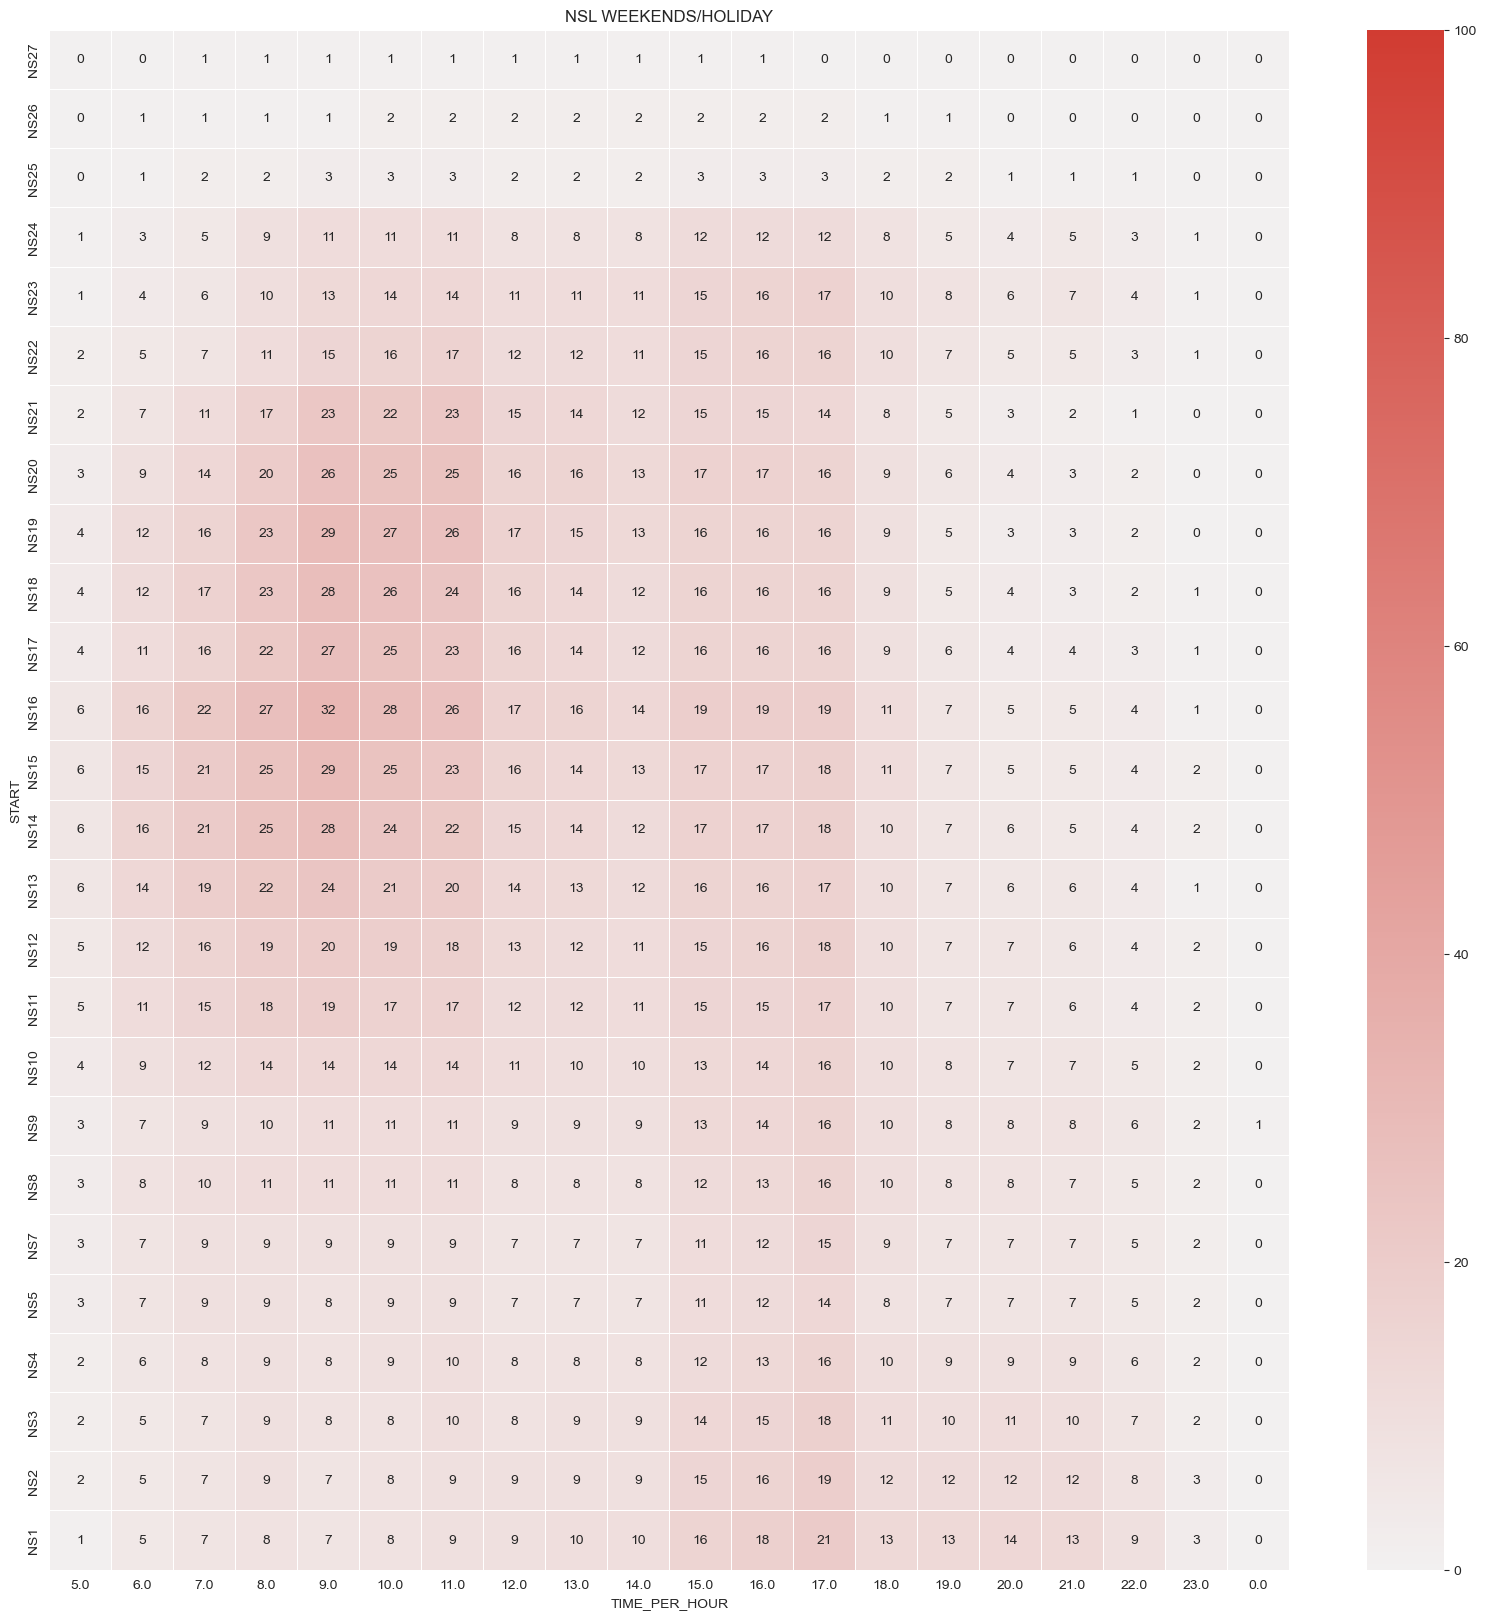

In [107]:
line_code = 'NSL'
day_type = 'WEEKENDS/HOLIDAY'

station_codes = extract_same_line_codes(all_lines[line_code]['station_codes'], all_lines[line_code]['line_prefixes'])

data_df = counts_df[counts_df['DAY_TYPE'].str.contains(day_type)]
section_index = pd.MultiIndex.from_frame(data_df[['START', 'END']])

forward_sections = [(station_codes[i], station_codes[i+1]) for i in range(len(station_codes) - 1)]
forward_df = data_df[section_index.isin(forward_sections)]
forward_df = forward_df.set_index(['TIME_PER_HOUR', 'START'])['CROWDEDNESS']
forward_df = forward_df.unstack('TIME_PER_HOUR')[hours]
forward_df = forward_df.reindex(reversed(station_codes[:-1]))

plt.figure(figsize = (20,20))
sns.set_style('white')
cmap = sns.light_palette('#{:02x}{:02x}{:02x}'.format(*all_lines[line_code]['line_color']), as_cmap=True)
sns.heatmap(forward_df, cmap=cmap, linewidths=0.5, annot=True, fmt='g', vmin=0, vmax=100)
# pos, text = plt.yticks()
# _, _ = plt.yticks(pos - 0.5, all_lines[line_code])
plt.title(line_code + " " + day_type)


In [380]:
def create_train(cx, cy, color, value, min, max, direction):
    # Creates a train graphic centered at (cx, cy), with a fill amount relative to value, min and max, facing in the specified direction
    train_width = 15
    train_length = train_width * (1 + 5 ** 0.5)
    corner_rounding = 4
    stroke_width = 1.5
    direction_offset = 10

    x_size = train_length if (direction == 'left' or direction == 'right') else train_width
    y_size = train_width if (direction == 'left' or direction == 'right') else train_length

    x = cx - x_size/2
    y = cy - y_size/2

    fill_amount = np.tanh(3 * ((value - min) / (max - min)))

    clip_x = x - direction_offset if direction == 'left' else x + direction_offset if direction == 'right' else x - stroke_width
    clip_y = y - direction_offset if direction == 'up' else y + direction_offset if direction == 'down' else y - stroke_width

    clip = dw.ClipPath([dw.Rectangle(clip_x, clip_y, x_size + 2 * stroke_width, y_size + 2 * stroke_width, stroke_width=stroke_width, fill=color, fill_opacity=0.3)])

    grad_sx = 1 if direction == 'left' else 0
    grad_sy = 1 if direction == 'up' else 0
    grad_ex = 1 if direction == 'right' else 0
    grad_ey = 1 if direction == 'down' else 0

    grad = dw.LinearGradient(grad_sx, grad_sy, grad_ex, grad_ey, 'objectBoundingBox')
    grad.add_stop(0, color, opacity=0)
    grad.add_stop(0.4, color, opacity=1)
    grad.add_stop(1, color, opacity=1)

    outer = dw.Rectangle(x, y, x_size, y_size, ry=corner_rounding, stroke=grad, stroke_width=stroke_width, fill='none', clip_path=clip)

    inner_x = x + direction_offset - corner_rounding + (1-fill_amount) * (x_size - direction_offset) if direction == 'right' else x
    inner_y = y + direction_offset - corner_rounding + (1-fill_amount) * (y_size - direction_offset) if direction == 'down' else y
    inner_x_size = x_size if (direction == 'up' or direction == 'down') else fill_amount * (x_size - direction_offset) + corner_rounding
    inner_y_size = y_size if (direction == 'left' or direction == 'right') else fill_amount * (y_size - direction_offset) + corner_rounding

    inner = dw.Rectangle(inner_x, inner_y, inner_x_size, inner_y_size, ry=corner_rounding, stroke='none', fill=color, fill_opacity=fill_amount)

    return dw.Group([clip, inner, outer])

In [392]:
def create_line(sx, sy, spacing, line_colors, text_colors, marker_colors, names, direction):
    line_colors = [line_colors] * len(names) if type(line_colors) is str else line_colors
    marker_colors = [marker_colors] * len(names) if type(marker_colors) is str else marker_colors
    text_colors = [text_colors] * len(names) if type(text_colors) is str else text_colors

    width = 40
    height = 26
    corner_rounding_x = 7.5
    corner_rounding_y = 15
    stroke_width = 5
    font_size = 9

    n = len(names)

    # ex = sx + (1 if direction == 'right' else -1 if direction == 'left' else 0) * (n-1) * spacing
    # ey = sy + (1 if direction == 'down' else -1 if direction == 'up' else 0) * (n-1) * spacing

    lsx = sx
    lsy = sy
    lines = []
    for i in range(n-1):
        lex = lsx + (1 if direction == 'right' else -1 if direction == 'left' else 0) * spacing
        ley = lsy + (1 if direction == 'down' else -1 if direction == 'up' else 0) * spacing

        lines.append(dw.Line(lsx, lsy, lex, ley, stroke=line_colors[i], stroke_width=stroke_width))

        lsx = lex
        lsy = ley
    # line = dw.Line(sx, sy, ex, ey, stroke=colors[0], stroke_width=stroke_width)

    stations = []
    for i, name in enumerate(names):
        x = sx - width / 2 + (i if direction == 'right' else -i if direction == 'left' else 0) * spacing
        y = sy - height / 2 + (i if direction == 'down' else -i if direction == 'up' else 0) * spacing
        station = dw.Rectangle(x, y, width, height, rx=corner_rounding_x, ry=corner_rounding_y, stroke='white', stroke_width=2, fill=marker_colors[i])

        tx = sx + (i if direction == 'right' else -i if direction == 'left' else 0) * spacing
        ty = sy + (i if direction == 'down' else -i if direction == 'up' else 0) * spacing
        name = dw.Text(text=name, x=tx, y=ty, font_size=font_size, font_weight='bold', fill=text_colors[i], text_anchor='middle', dominant_baseline='middle')

        stations.append(dw.Group([station, name]))
    
    return dw.Group(lines + stations)

In [393]:
def draw_heatmap(counts_df, station_codes, day_type, data_min=None, data_max=None, col='CROWDEDNESS'):
    print("Drawing heatmap for line: ", station_codes)
    station_spacing = 55
    time_spacing = 55

    left_margin = 130
    top_margin = 50
    
    data_df = counts_df[
        counts_df['START'].isin(station_codes) &
        counts_df['END'].isin(station_codes) &
        counts_df['DAY_TYPE'].str.contains(day_type)
    ]

    data_max = np.max(data_df[col]) if data_max is None else data_max
    data_min = np.min(data_df[col]) if data_min is None else data_min

    canvas_width = 1430
    canvas_height = len(station_codes) * station_spacing + top_margin

    d = dw.Drawing(canvas_width, canvas_height, id_prefix=f'{line_code}_{day_type.replace("/", "_")}', font_family='Verdana')

    # Draw Background
    bg = dw.Rectangle(0, 0, canvas_width, canvas_height, fill='white')
    d.append(bg)

    # Draw Station Axis
    station_line_height = 500
    station_sx = left_margin
    station_sy = top_margin + station_spacing / 2
    station_colors = ['rgb' + str(prefix_colors[station_code[:2]]) for station_code in station_codes]
    forward_line = create_line(station_sx, station_sy, station_spacing, station_colors, 'white', station_colors, station_codes, 'down')
    d.append(forward_line)

    # Name Column
    station_names = [station_name_df.loc[station_code]['mrt_station_english'] for station_code in station_codes]
    for i, station_name in enumerate(station_names):
        t = dw.Text(textwrap.wrap(station_name, width=10), 11, station_sx - 65, station_sy + i * station_spacing, fill='rgb(43, 41, 37)', font_weight='bold', text_anchor='middle', dominant_baseline='middle')
        d.append(t)

    # Draw Time Axis
    time_names = ['{:02d}:00'.format(i) for i in list(range(5, 24)) + [0, 1]]
    time_sx = left_margin + time_spacing / 2
    time_sy = top_margin
    time_line = create_line(time_sx, time_sy, time_spacing, station_colors[0], 'white', station_colors[0], time_names, 'right')
    d.append(time_line)

    forward_backward_gap = 20

    # Draw Forward Data
    forward_sections = [(station_codes[i], station_codes[i+1]) for i in range(len(station_codes) - 1)]
    forward_df = data_df.set_index(['TIME_PER_HOUR', 'START', 'END'])[col]
    forward_df = forward_df.unstack('TIME_PER_HOUR')[hours]
    forward_df = forward_df.join(pd.DataFrame(index=pd.MultiIndex.from_tuples(forward_sections, names=['START', 'END'])), how='right')

    forward_grid_origin_x = time_sx + time_spacing / 2 - forward_backward_gap / 2
    forward_grid_origin_y = station_sy + (station_spacing / 2)
    for y, station_code in enumerate(station_codes[:-1]):
        for x, hour in enumerate(hours):
            d.append(create_train(
                forward_grid_origin_x + x * time_spacing, 
                forward_grid_origin_y + y * station_spacing, 
                'rgb'+ str(prefix_colors[station_code[:2]]), 
                forward_df[hour].get(station_code, 0).squeeze(), data_min, data_max,
                'down'
            ))

    # Draw Backward Data
    backward_sections = [(station_codes[::-1][i], station_codes[::-1][i+1]) for i in range(len(station_codes) - 1)]
    backward_df = data_df.set_index(['TIME_PER_HOUR', 'START', 'END'])[col]
    backward_df = backward_df.unstack('TIME_PER_HOUR')[hours]
    backward_df = backward_df.join(pd.DataFrame(index=pd.MultiIndex.from_tuples(backward_sections, names=['START', 'END'])), how='right')

    backward_grid_origin_x = forward_grid_origin_x + forward_backward_gap
    backward_grid_origin_y = forward_grid_origin_y
    for y, station_code in enumerate(station_codes[1:]):
        for x, hour in enumerate(hours):
            d.append(create_train(
                backward_grid_origin_x + x * time_spacing, 
                backward_grid_origin_y + y * station_spacing, 
                'rgb'+ str(prefix_colors[station_code[:2]]), 
                backward_df[hour].get(station_code, 0).squeeze(), data_min, data_max,
                'up'
            ))

    # Draw Color Bar
    color_bar_width = 50
    color_bar_x = left_margin + time_spacing / 2 + len(hours) * time_spacing + time_spacing / 2
    color_bar_y = station_sy
    color_bar_height = (len(station_codes)-1) * station_spacing

    color_bar_grad = dw.LinearGradient(0, 0, 0, color_bar_height)
    color_bar_grad.add_stop(0, 'white')
    color_bar_grad.add_stop(1, station_colors[0])

    color_bar = dw.Rectangle(color_bar_x, color_bar_y, color_bar_width, color_bar_height, fill=color_bar_grad, rx=5, stroke=station_colors[0], stroke_width=1.5)

    tick_color = 'rgb(43, 41, 37)'
    tick_font_size = 9
    num_ticks = 5
    tick_values = np.linspace(data_min, data_max, num_ticks)
    ticks = [
        dw.Text(
            f"{value:.0f}", 
            tick_font_size, 
            color_bar_x + color_bar_width + 5, 
            color_bar_y + i * (color_bar_height / (num_ticks-1)), 
            font_weight='bold', 
            fill=tick_color, 
            text_anchor='left', 
            dominant_baseline='middle'
        )
        for i, value in enumerate(tick_values)
    ]
    d.append(dw.Group([color_bar] + ticks))

    return d, forward_df, backward_df

Drawing heatmap for line:  ['NS16', 'NS17', 'CC15', 'CC16', 'CC17', 'CC19', 'CC20', 'CC21', 'CC22', 'EW21', 'EW20']


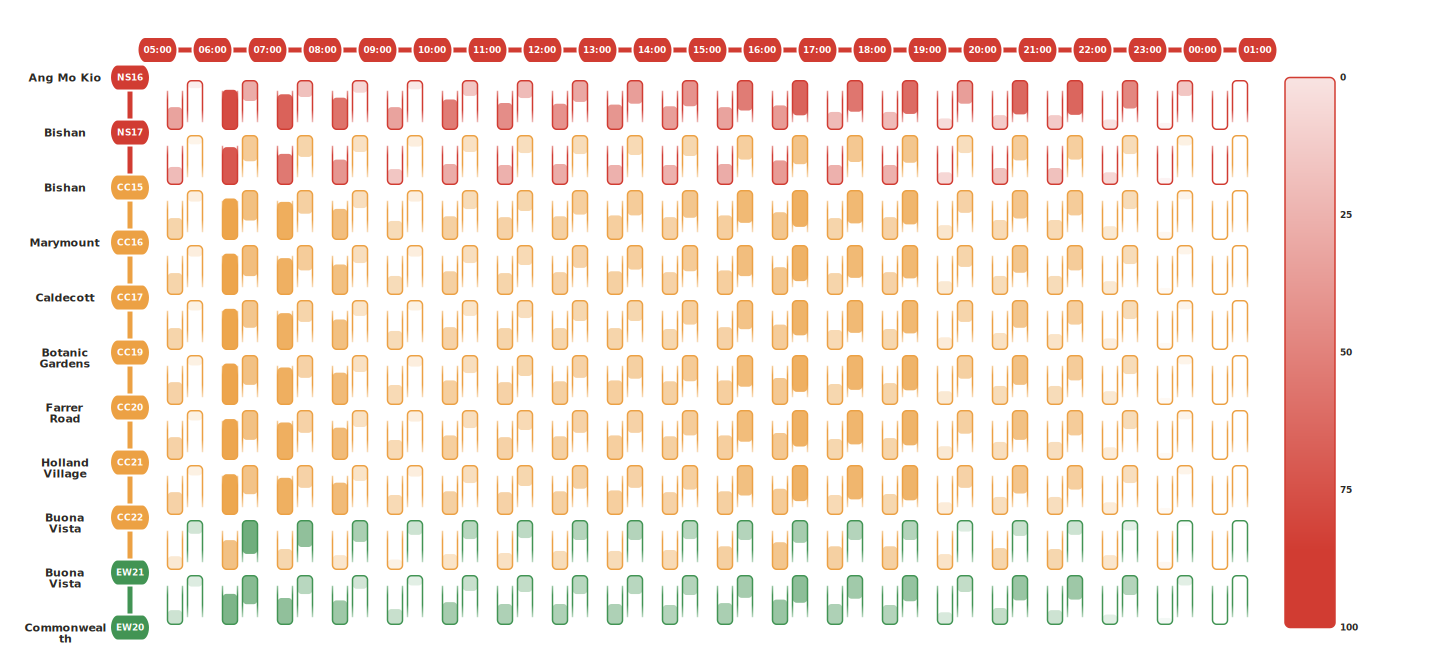

In [394]:
custom_line = nx.shortest_path(network_graph, 'NS16', 'CC24')
custom_line = nx.shortest_path(network_graph, 'DT5', 'TE7')
custom_line = nx.shortest_path(network_graph, 'EW33', 'CG2')
custom_line = nx.shortest_path(network_graph, 'NS16', 'EW20')
# custom_line = extract_same_line_codes(all_lines['EWL']['station_codes'], all_lines['EWL']['line_prefixes'])
d, forward_df, backward_df = draw_heatmap(counts_df, custom_line, 'WEEKDAY', data_min=0, data_max=100)
d

Drawing heatmap for line:  ['NS1', 'NS2', 'NS3', 'NS4', 'NS5', 'NS7', 'NS8', 'NS9', 'NS10', 'NS11', 'NS12', 'NS13', 'NS14', 'NS15', 'NS16', 'NS17', 'NS18', 'NS19', 'NS20', 'NS21', 'NS22', 'NS23', 'NS24', 'NS25', 'NS26', 'NS27', 'NS28']
Drawing heatmap for line:  ['NS1', 'NS2', 'NS3', 'NS4', 'NS5', 'NS7', 'NS8', 'NS9', 'NS10', 'NS11', 'NS12', 'NS13', 'NS14', 'NS15', 'NS16', 'NS17', 'NS18', 'NS19', 'NS20', 'NS21', 'NS22', 'NS23', 'NS24', 'NS25', 'NS26', 'NS27', 'NS28']
Drawing heatmap for line:  ['EW1', 'EW2', 'EW3', 'EW4', 'EW5', 'EW6', 'EW7', 'EW8', 'EW9', 'EW10', 'EW11', 'EW12', 'EW13', 'EW14', 'EW15', 'EW16', 'EW17', 'EW18', 'EW19', 'EW20', 'EW21', 'EW22', 'EW23', 'EW24', 'EW25', 'EW26', 'EW27', 'EW28', 'EW29', 'EW30', 'EW31', 'EW32', 'EW33']
Drawing heatmap for line:  ['EW1', 'EW2', 'EW3', 'EW4', 'EW5', 'EW6', 'EW7', 'EW8', 'EW9', 'EW10', 'EW11', 'EW12', 'EW13', 'EW14', 'EW15', 'EW16', 'EW17', 'EW18', 'EW19', 'EW20', 'EW21', 'EW22', 'EW23', 'EW24', 'EW25', 'EW26', 'EW27', 'EW28', 'E

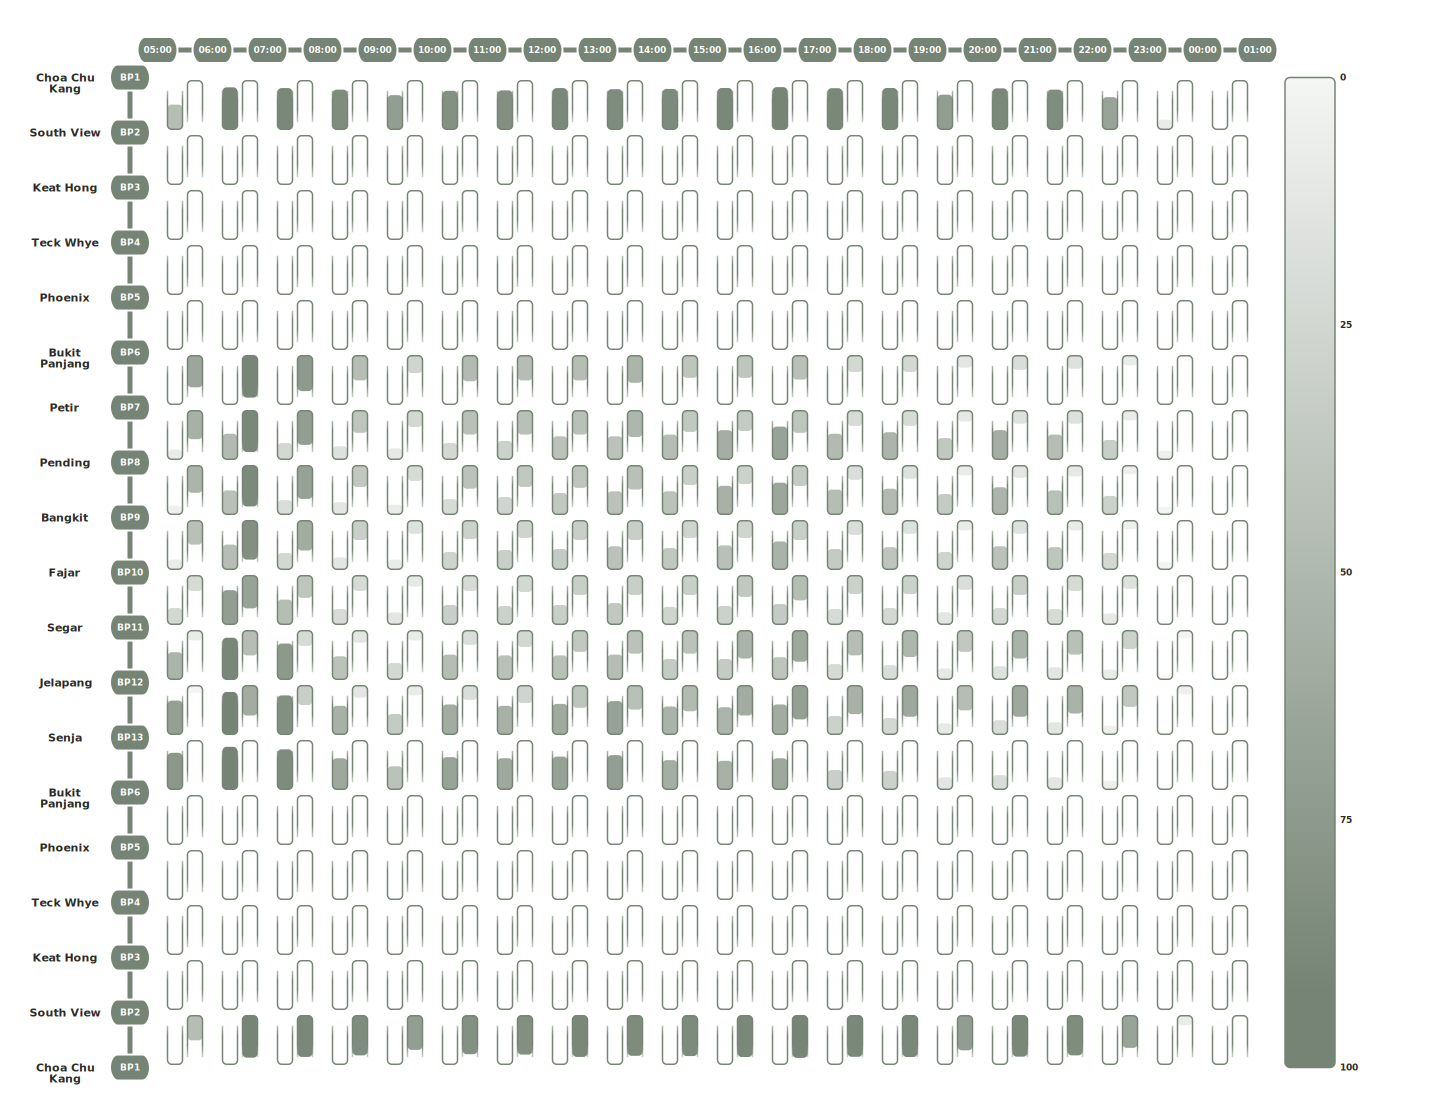

In [395]:
for line_code, data in all_lines.items():
    station_codes = extract_same_line_codes(data['station_codes'], data['line_prefixes'])
    for day_type in day_types:
        d, _, _ = draw_heatmap(counts_df, station_codes, day_type, data_min=0, data_max=100)

        d.save_svg(f'graphics/{line_code}_{day_type.replace("/", "_")}.svg')
        d.save_png(f'graphics/{line_code}_{day_type.replace("/", "_")}.png')

d

In [113]:
station_codes = extract_same_line_codes(all_lines['BPLRT']['station_codes'], all_lines['BPLRT']['line_prefixes'])
data_df = counts_df[
    counts_df['START'].isin(station_codes) &
    counts_df['END'].isin(station_codes) &
    counts_df['DAY_TYPE'].str.contains(day_type)
]

# backward_sections = [(station_codes[::-1][i], station_codes[::-1][i+1]) for i in range(len(station_codes) - 1)]
# backward_df = data_df[['TIME_PER_HOUR', 'START', 'END', 'COUNT']].set_index(['TIME_PER_HOUR', 'START', 'END'])['COUNT']
# backward_df = backward_df.unstack('TIME_PER_HOUR')[hours]
# backward_df = backward_df.join(pd.DataFrame(index=pd.MultiIndex.from_tuples(backward_sections, names=['START', 'END'])), how='right')
# backward_df

forward_sections = [(station_codes[i], station_codes[i+1]) for i in range(len(station_codes) - 1)]
forward_df = data_df.set_index(['TIME_PER_HOUR', 'START', 'END'])['COUNT']
# forward_df = forward_df.unstack('TIME_PER_HOUR')[hours]
# forward_df = forward_df.join(pd.DataFrame(index=pd.MultiIndex.from_tuples(forward_sections, names=['START', 'END'])), how='right')
forward_df.loc[7]



START  END 
BP1    BP2     25493.776233
BP10   BP11     7480.699441
       BP9     10249.537151
BP11   BP10     6358.710913
       BP12    14583.522973
BP12   BP11     3763.534445
       BP13    18753.450271
BP13   BP12     5226.461743
       BP6     21032.533605
BP2    BP1     30835.049405
       BP3     30070.587219
BP3    BP2     27836.860391
       BP4     34683.316807
BP4    BP3     22761.589979
       BP5     27747.666290
BP5    BP4     24885.939462
       BP6     29280.885534
BP6    BP13     5322.545077
       BP5     24917.158706
       BP7      4735.288257
BP7    BP6     14473.299729
       BP8      4033.454923
BP8    BP7     13180.466395
       BP9      3465.707284
BP9    BP10     4106.525679
       BP8     12315.718756
Name: COUNT, dtype: float64